In [1]:
import torch
from torch import nn
from torch.optim import SGD, Adam
from annpy.models.gan import GAN
from annpy.training import GANTrainer
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchtrainer.callbacks import Logger
from torchtrainer.utils.data.datasets import UnsuperviseDataset
import matplotlib.pyplot as plt


WIDTH=28
HEIGHT=28
USE_CUDA=True

In [2]:
class Discriminator(nn.Module):
    """ GAN Model for generate MNIST digits """
    def __init__(self, last_act=None):
        super(Discriminator, self).__init__()

        self._filter = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32,kernel_size=5,padding=0,stride=1),
                                          nn.BatchNorm2d(32),
                                          nn.LeakyReLU(inplace=True),
                                          nn.Dropout(0.5),
                                          nn.MaxPool2d(2),
                                          nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
                                          nn.BatchNorm2d(64),
                                          nn.LeakyReLU(inplace=True),
                                          nn.Dropout(0.5),
                                          nn.MaxPool2d(2))
                                          # nn.Dropout(0.5))
        self._classifier = nn.Sequential(nn.Linear(6*6*64, 1),
                                         nn.Dropout(0.2)
                                         )

    def forward(self, x):
        x = self._filter(x)
        # print(x.shape)
        x = x.view(x.shape[0], -1)
        x = self._classifier(x)
        return x

    def filter_params(self, cond):
        params = []
        for name, p in self.named_parameters():
            if cond(name):
                params.append(p)
        return params

    def weights_parameters(self):
        return self.filter_params(lambda name: not ('bias' in name))

    def bias_parameters(self):
        return self.filter_params(lambda name: 'bias' in name)

    @property
    def input_shape(self):
        return (1, 28, 28)

class Generator(nn.Module):
    """ GAN Model for generate MNIST digits """
    def __init__(self, last_act=None):
        super(Generator, self).__init__()
        self._layers = nn.Sequential(nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=8, stride=4, padding=0),
                                     nn.BatchNorm2d(128),
                                     nn.LeakyReLU(inplace=True),
                                     nn.Dropout(0.5),
                                     nn.ConvTranspose2d(in_channels=128, out_channels=256, kernel_size=6, stride=3, padding=0),
                                     nn.BatchNorm2d(256),
                                     nn.LeakyReLU(inplace=True),
                                     nn.Dropout(0.5),
                                     nn.ConvTranspose2d(in_channels=256, out_channels=1, kernel_size=2, stride=1, padding=0),
                                     nn.BatchNorm2d(1),
                                     # # nn.BatchNorm2d(1),
                                     nn.Sigmoid(),
                                     # nn.Dropout(0.2),
                                     )


    def forward(self, x):
        x = x.view(-1,64,1, 1)
        return self._layers(x)

    def filter_params(self, cond):
        params = []
        for name, p in self.named_parameters():
            if cond(name):
                params.append(p)
        return params

    def weights_parameters(self):
        return self.filter_params(lambda name: not ('bias' in name))

    def bias_parameters(self):
        return self.filter_params(lambda name: 'bias' in name)
    
    @property
    def input_shape(self):
        return (64, )

In [3]:
gen = Generator()
dis = Discriminator()

In [4]:
gen

Generator(
  (_layers): Sequential(
    (0): ConvTranspose2d (64, 128, kernel_size=(8, 8), stride=(4, 4))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (2): LeakyReLU(0.01, inplace)
    (3): Dropout(p=0.5)
    (4): ConvTranspose2d (128, 256, kernel_size=(6, 6), stride=(3, 3))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (6): LeakyReLU(0.01, inplace)
    (7): Dropout(p=0.5)
    (8): ConvTranspose2d (256, 1, kernel_size=(2, 2), stride=(1, 1))
    (9): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True)
    (10): Sigmoid()
  )
)

In [5]:
dis

Discriminator(
  (_filter): Sequential(
    (0): Conv2d (1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (2): LeakyReLU(0.01, inplace)
    (3): Dropout(p=0.5)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d (32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (7): LeakyReLU(0.01, inplace)
    (8): Dropout(p=0.5)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (_classifier): Sequential(
    (0): Linear(in_features=2304, out_features=1)
    (1): Dropout(p=0.2)
  )
)

In [6]:
m = GAN(discriminator=dis, generator=gen)

In [7]:
def showsample():
    sample = m.sample(1).data[0]
    im = sample.view(WIDTH,HEIGHT)
    if USE_CUDA:
        im = im.cpu()
    plt.imshow(im.numpy())
    plt.colorbar()
    plt.show()

In [8]:
g_optimizer = Adam(m.generator.parameters(), lr=1e-2, weight_decay=0, betas=(0.5, 0.999))
d_optimizer = Adam(m.discriminator.parameters(), lr=1e-2, weight_decay=0, betas=(0.5, 0.999))

In [9]:
trainer = GANTrainer(m,
                     d_optimizer,
                     g_optimizer,
                     callbacks=[Logger()],
                     logging_frecuency=50,
                     soft_labels_eps=0)

In [10]:
transform = transforms.Compose([transforms.Resize((WIDTH, HEIGHT)),
                                transforms.ToTensor()])

In [11]:
train_ds = UnsuperviseDataset(MNIST(root='data', download=True, train=True, transform=transform))
test_ds = UnsuperviseDataset(MNIST(root='data', download=False, train=False, transform=transform))

In [12]:
train_ds[0].shape

torch.Size([1, 28, 28])

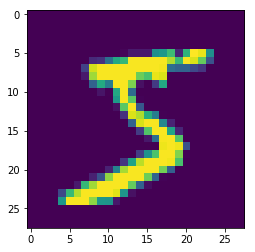

In [13]:
plt.imshow(train_ds[0].view(WIDTH, HEIGHT).numpy())
plt.show()

In [14]:
dataloader = DataLoader(train_ds, batch_size=256)
test_dl = DataLoader(test_ds, batch_size=256)

In [15]:
if USE_CUDA:
    trainer.cuda()

In [16]:
trainer.train(dataloader,
              valid_dataloader=test_dl,
              epochs=1)

epoch: 0/1,	step: 49/235,	train_g_loss: 1.726,	train_loss: 3.206,	train_d_loss: 1.480
epoch: 0/1,	step: 99/235,	train_g_loss: 0.758,	train_loss: 1.530,	train_d_loss: 0.772
epoch: 0/1,	step: 149/235,	train_g_loss: 0.611,	train_loss: 1.222,	train_d_loss: 0.611
epoch: 0/1,	step: 199/235,	train_g_loss: 0.571,	train_loss: 1.170,	train_d_loss: 0.598
epoch: 0/1,	step: 234/235,	val_loss: 3.803,	train_d_loss: 0.557,	train_loss: 1.118,	train_g_loss: 0.561,	val_d_loss: 1.247,	val_g_loss: 2.556


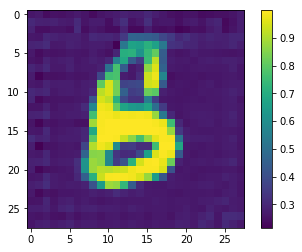

In [18]:
m.eval()
showsample()

In [20]:
trainer.train(dataloader,
              valid_dataloader=test_dl,
              epochs=1)

epoch: 0/1,	step: 49/235,	train_g_loss: 0.503,	train_loss: 1.002,	train_d_loss: 0.499
epoch: 0/1,	step: 99/235,	train_g_loss: 0.454,	train_loss: 0.915,	train_d_loss: 0.460
epoch: 0/1,	step: 149/235,	train_g_loss: 0.555,	train_loss: 1.106,	train_d_loss: 0.551
epoch: 0/1,	step: 199/235,	train_g_loss: 0.517,	train_loss: 1.048,	train_d_loss: 0.530
epoch: 0/1,	step: 234/235,	val_loss: 1.531,	train_d_loss: 0.437,	train_loss: 0.887,	train_g_loss: 0.451,	val_d_loss: 0.420,	val_g_loss: 1.111


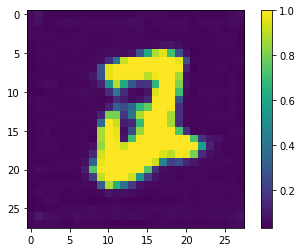

In [22]:
m.eval()
showsample()

In [24]:
trainer.train(dataloader,
              valid_dataloader=test_dl,
              epochs=40)

epoch: 0/40,	step: 49/235,	train_g_loss: 0.432,	train_loss: 0.871,	train_d_loss: 0.439
epoch: 0/40,	step: 99/235,	train_g_loss: 0.489,	train_loss: 1.037,	train_d_loss: 0.548
epoch: 0/40,	step: 149/235,	train_g_loss: 0.491,	train_loss: 0.980,	train_d_loss: 0.489
epoch: 0/40,	step: 199/235,	train_g_loss: 0.433,	train_loss: 0.871,	train_d_loss: 0.438
epoch: 0/40,	step: 234/235,	val_loss: 1.623,	train_d_loss: 0.419,	train_loss: 0.825,	train_g_loss: 0.406,	val_d_loss: 0.215,	val_g_loss: 1.408
epoch: 1/40,	step: 49/235,	train_g_loss: 0.424,	train_loss: 0.868,	train_d_loss: 0.443
epoch: 1/40,	step: 99/235,	train_g_loss: 0.401,	train_loss: 0.826,	train_d_loss: 0.425
epoch: 1/40,	step: 149/235,	train_g_loss: 0.402,	train_loss: 0.833,	train_d_loss: 0.431
epoch: 1/40,	step: 199/235,	train_g_loss: 0.382,	train_loss: 0.757,	train_d_loss: 0.375
epoch: 1/40,	step: 234/235,	val_loss: 1.152,	train_d_loss: 0.382,	train_loss: 0.781,	train_g_loss: 0.399,	val_d_loss: 0.365,	val_g_loss: 0.787
epoch: 2/40,	s

epoch: 16/40,	step: 199/235,	train_g_loss: 0.299,	train_loss: 0.593,	train_d_loss: 0.295
epoch: 16/40,	step: 234/235,	val_loss: 3.022,	train_d_loss: 0.311,	train_loss: 0.650,	train_g_loss: 0.338,	val_d_loss: 0.019,	val_g_loss: 3.003
epoch: 17/40,	step: 49/235,	train_g_loss: 0.356,	train_loss: 0.738,	train_d_loss: 0.382
epoch: 17/40,	step: 99/235,	train_g_loss: 0.331,	train_loss: 0.650,	train_d_loss: 0.319
epoch: 17/40,	step: 149/235,	train_g_loss: 0.352,	train_loss: 0.720,	train_d_loss: 0.369
epoch: 17/40,	step: 199/235,	train_g_loss: 0.332,	train_loss: 0.685,	train_d_loss: 0.353
epoch: 17/40,	step: 234/235,	val_loss: 4.358,	train_d_loss: 0.305,	train_loss: 0.593,	train_g_loss: 0.288,	val_d_loss: 0.006,	val_g_loss: 4.352
epoch: 18/40,	step: 49/235,	train_g_loss: 0.356,	train_loss: 0.726,	train_d_loss: 0.370
epoch: 18/40,	step: 99/235,	train_g_loss: 0.355,	train_loss: 0.730,	train_d_loss: 0.375
epoch: 18/40,	step: 149/235,	train_g_loss: 0.342,	train_loss: 0.676,	train_d_loss: 0.334
epoc

epoch: 32/40,	step: 234/235,	val_loss: 10.247,	train_d_loss: 0.255,	train_loss: 0.503,	train_g_loss: 0.248,	val_d_loss: 0.000,	val_g_loss: 10.247
epoch: 33/40,	step: 49/235,	train_g_loss: 0.380,	train_loss: 0.775,	train_d_loss: 0.395
epoch: 33/40,	step: 99/235,	train_g_loss: 0.268,	train_loss: 0.544,	train_d_loss: 0.276
epoch: 33/40,	step: 149/235,	train_g_loss: 0.329,	train_loss: 0.676,	train_d_loss: 0.347
epoch: 33/40,	step: 199/235,	train_g_loss: 0.316,	train_loss: 0.630,	train_d_loss: 0.314
epoch: 33/40,	step: 234/235,	val_loss: 12.930,	train_d_loss: 0.316,	train_loss: 0.615,	train_g_loss: 0.299,	val_d_loss: 0.000,	val_g_loss: 12.930
epoch: 34/40,	step: 49/235,	train_g_loss: 0.368,	train_loss: 0.753,	train_d_loss: 0.385
epoch: 34/40,	step: 99/235,	train_g_loss: 0.281,	train_loss: 0.570,	train_d_loss: 0.289
epoch: 34/40,	step: 149/235,	train_g_loss: 0.306,	train_loss: 0.613,	train_d_loss: 0.307
epoch: 34/40,	step: 199/235,	train_g_loss: 0.249,	train_loss: 0.492,	train_d_loss: 0.244


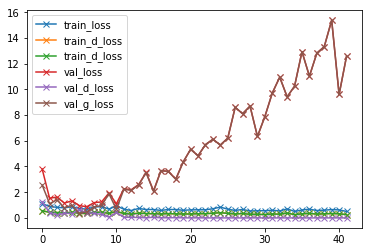

In [25]:
trainer.history.epoch_plot('train_loss')
trainer.history.epoch_plot('train_d_loss')
trainer.history.epoch_plot('train_d_loss')
trainer.history.epoch_plot('val_loss')
trainer.history.epoch_plot('val_d_loss')
trainer.history.epoch_plot('val_g_loss')
plt.legend()
plt.show()

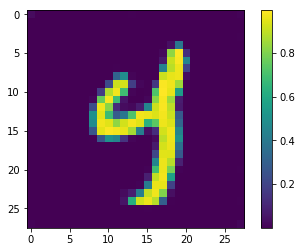

In [26]:
m.eval()
showsample()